<h1><center>Pharmaceutical-Sales-prediction </center></h1>

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import SimpleImputer
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score,r2_score
from urllib.parse import urlparse
import pickle
import dvc.api
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import logging
# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")


In [3]:
#Load training data 
path = 'data/train.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'train_v1'
data_url2 = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
train_data=pd.read_csv(data_url2)
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
#load test data
path = 'data/test.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'test_v1'
data_url3 = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
test_data=pd.read_csv(data_url3)
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
#load store data
path = 'data/store.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'store_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
store_data=pd.read_csv(data_url)
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# merge the train/test sets with the stores set
merged_train = pd.merge(left = train_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
merged_test = pd.merge(left = test_data, right = store_data, how = 'inner', left_on = 'Store', right_on = 'Store')
print(merged_train.shape)
print(merged_test.shape)
deep_train = merged_train.copy()
deep_test = merged_test.copy()

(1017209, 18)
(41088, 17)


In [7]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [8]:
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

In [9]:
def preprocess_data(train, test):
    
    # '''preprocessing'''
    global train_features, test_features, train_target, categorical, numerical

    # train and target features
    train_features = train.drop(['Sales', 'Customers'], axis = 1) #drop the target feature + customers (~ will not be used for prediction)
    train_target  = train[['Sales']]
    test_features = test.drop(['Id'], axis = 1) #drop id, it's required only during submission

    #feature generation + transformations
    train_features['Date'] = pd.to_datetime(train_features.Date)
    train_features['Month'] = train_features.Date.dt.month.to_list()
    train_features['Year'] = train_features.Date.dt.year.to_list()
    train_features['Day'] = train_features.Date.dt.day.to_list()
    train_features['WeekOfYear'] = train_features.Date.dt.weekofyear.to_list()
    train_features['DayOfWeek'] = train_features.Date.dt.dayofweek.to_list()
    train_features['weekday'] = 1        # Initialize the column with default value of 1
    train_features.loc[train_features['DayOfWeek'] == 5, 'weekday'] = 0
    train_features.loc[train_features['DayOfWeek'] == 6, 'weekday'] = 0
    train_features = train_features.drop(['Store'], axis = 1)

    test_features['Date'] = pd.to_datetime(test_features.Date)
    test_features['Month'] = test_features.Date.dt.month.to_list()
    test_features['Year'] = test_features.Date.dt.year.to_list()
    test_features['Day'] = test_features.Date.dt.day.to_list()
    test_features['WeekOfYear'] = test_features.Date.dt.weekofyear.to_list()
    test_features['DayOfWeek'] = test_features.Date.dt.dayofweek.to_list()
    test_features['weekday'] = 1        # Initialize the column with default value of 1
    test_features.loc[test_features['DayOfWeek'] == 5, 'weekday'] = 0
    test_features.loc[test_features['DayOfWeek'] == 6, 'weekday'] = 0
    test_features = test_features.drop(['Store'], axis = 1)


    # numerical and categorical columns (train set)
    categorical = []
    numerical = []
    timestamp = []

    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"



    # ''' actual preprocessing: the mighty pipeline '''
    # numeric
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 
    features.PromoInterval = features.PromoInterval.fillna(features.PromoInterval.mode()[0])
    features.Open = features.Open.fillna(features.Open.mode()[0])
    features = pd.get_dummies(features, columns=['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'])
    
    scaler = RobustScaler()
    c = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'WeekOfYear', 'Month', 'Year', 'Day', 'WeekOfYear', 'weekday']
    features[numerical] = scaler.fit_transform(features[numerical].values)
    print(features[numerical].columns)

    return features

In [10]:
features = preprocess_data(merged_train, merged_test)
features = features.drop(['Date'], axis = 1)
features.head()


Index(['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Year', 'Day',
       'WeekOfYear', 'weekday'],
      dtype='object')


,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
1,0.00,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
2,-0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
3,-0.50,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
4,-0.75,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0


In [11]:
# a function  to create and save logs in the log files
def log(path, file):
    """[Create a log file to record the experiment's logs]
    
    Arguments:
        path {string} -- path to the directory
        file {string} -- file name
    
    Returns:
        [obj] -- [logger that record logs]
    """

    # check if the file exist
    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    # configure logger
    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    # create a file handler for output file
    handler = logging.FileHandler(log_file)

    # set the logging level for log file
    handler.setLevel(logging.INFO)
    
    # create a logging format
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    # add the handlers to the logger
    logger.addHandler(handler)

    return logger

## Modelling

In [12]:
# reconstruct train and test sets
def reconstruct_sets(features):
    global x_train, x_val, y_train, y_val
    # global train_set
    # original train and test sets
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    # train_set = pd.concat([x_train, y_train], axis=1)

    # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)


    return x_train, x_val, y_train, y_val, x_test

In [13]:
x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features)
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape

((813767, 29), (203442, 29), (813767,), (203442,), (41088, 29))

In [14]:

with mlflow.start_run():
    n_estimators = 15
    clf=RandomForestRegressor(n_estimators=n_estimators)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_val)
    print("Mean squared error for RF on validation data =", mean_squared_error(y_val, y_pred))
    print("Mean absolute error for RF on validation data =", mean_absolute_error(y_val, y_pred))
    print("Mean R2 score for xgb on validation data =", r2_score(y_val, y_pred))
    mlflow.log_param("normalize", n_estimators)
    mlflow.log_metric("mse", mean_squared_error(y_val, y_pred))
    mlflow.log_metric("r2", r2_score(y_val, y_pred))
    mlflow.log_metric("mae", mean_absolute_error(y_val, y_pred))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(clf, "model", registered_model_name="RandomForestRegressor")
    else:
        mlflow.sklearn.log_model(clf, "model")


Mean squared error for RF on validation data = 0.018001217919662783
Mean absolute error for RF on validation data = 0.0757678161763899
Mean R2 score for xgb on validation data = 0.9983550486014764


In [15]:
with mlflow.start_run():
    normalize = False
    copy_X = True
    regressor = LinearRegression(fit_intercept=True, normalize=normalize, copy_X=copy_X, n_jobs=None, positive=False)
    regressor.fit(x_train, y_train)
    regressor_pred = regressor.predict(x_val)
    
    print("Elasticnet model (normalize=%f, l1_copy_x=%f):" % (normalize, copy_X))
    print("Mean squared error for SLR on validation data =", mean_squared_error(y_val, regressor_pred))
    print("Mean absolute error for SLR on validation data =", mean_absolute_error(y_val, regressor_pred))
    print("Mean R2 score for xgb on validation data =", r2_score(y_val, regressor_pred))

    mlflow.log_param("normalize", normalize)
    mlflow.log_param("copy_X", copy_X)
    mlflow.log_metric("mse", mean_squared_error(y_val, regressor_pred))
    mlflow.log_metric("r2", r2_score(y_val, regressor_pred))
    mlflow.log_metric("mae", mean_absolute_error(y_val, regressor_pred))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(regressor, "model", registered_model_name="LinearRegression")
    else:
        mlflow.sklearn.log_model(regressor, "model")



Elasticnet model (normalize=0.000000, l1_copy_x=1.000000):
Mean squared error for SLR on validation data = 0.11848353838195011
Mean absolute error for SLR on validation data = 0.2527261289148492
Mean R2 score for xgb on validation data = 0.9891729735713871


In [16]:
with mlflow.start_run():
    alpha = 10
    learning_rate = 0.01
    xgb = XGBRegressor(learning_rate = 0.01, alpha = 10, random_state = 5)
    xgb.fit(x_train, y_train)
    xgb_pred = xgb.predict(x_val)
    print("Mean absolute error for xgb on validation data =", mean_absolute_error(y_val, xgb_pred))
    print("Mean squared error for xgb on validation data =", mean_squared_error(y_val, xgb_pred))
    print("Mean R2 score for xgb on validation data =", r2_score(y_val, xgb_pred))

    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("alpha", alpha)
    mlflow.log_metric("mse", mean_squared_error(y_val, xgb_pred))
    mlflow.log_metric("r2", r2_score(y_val, xgb_pred))
    mlflow.log_metric("mae", mean_absolute_error(y_val, xgb_pred))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri(),).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.xgboost.log_model(xgb, "model", registered_model_name="XGBRegressor")
    else:
        mlflow.xgboost.log_model(xgb, "model")

Mean absolute error for xgb on validation data = 2.5418202469873323
Mean squared error for xgb on validation data = 7.706876714943937
Mean R2 score for xgb on validation data = 0.295745560824075


Text(0.5, 1.0, 'MSE scores in the 4 models')

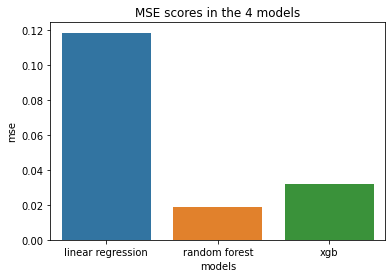

In [17]:
# Models performance
data = {'models':['linear regression', 'random forest', 'xgb'], 
        'mse':[0.11848353838195493, 0.018760600706471536, 0.03187670561363815 ],
        'mae':[0.2527261289148881, 0.2527261289148881, 0.12452815574403905]}
performance = pd.DataFrame(data, columns = ['models', 'mse', 'mae'])
sns.barplot(x = performance.models,  y = performance.mse)
plt.title('MSE scores in the 4 models')

- Based on MSE, RandomForest is the best option.

In [18]:
# Import attributes according to model
pd.options.display.float_format='{:.5f}'.format
important_features=pd.DataFrame(clf.feature_importances_,index=x_train.columns)
important_features.sort_values(by=0,ascending=False)

,0
Open,0.98592
CompetitionDistance,0.00372
Promo,0.00225
CompetitionOpenSinceYear,0.00130
CompetitionOpenSinceMonth,0.00125
DayOfWeek,0.00083
Day,0.00069
WeekOfYear,0.00063
Promo2SinceYear,0.00057
Promo2SinceWeek,0.00048


In [19]:
x_test.to_csv('test1.csv')

In [20]:
x_test.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.00000,0.00000,1.00000,0.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
1,-0.25000,0.00000,1.00000,0.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
2,-0.50000,0.00000,1.00000,0.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
3,-0.75000,0.00000,1.00000,0.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
4,0.75000,-1.00000,0.00000,0.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0


### Predictions

In [21]:
# make predictions using the random forest model
final_pred = clf.predict(x_test)
final_pred.shape

(41088,)

In [22]:
'''reconstruct a df with StoreID, date and Sales columns using the predcitions and the test set then save it as a csv file'''

sub = merged_test[['Id']]
back = np.expm1(final_pred)
sub['Sales'] = back
sub['Date'] = merged_test.Date.to_list()
sub['Store'] = merged_test.Store.to_list()
sub.to_csv('../data/predictions_for_test_data.csv', index = False)


In [23]:
features2 = preprocess_data(deep_train, deep_test)
features2 = features2.drop(['Date'], axis = 1)
features2.head()

Index(['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Year', 'Day',
       'WeekOfYear', 'weekday'],
      dtype='object')


,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25000,0.00000,1.00000,1.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
1,0.00000,0.00000,1.00000,1.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
2,-0.25000,0.00000,1.00000,1.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
3,-0.50000,0.00000,1.00000,1.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0
4,-0.75000,0.00000,1.00000,1.00000,-0.17208,0.66667,0.00000,-1.00000,0.00000,0.00000,...,1,0,0,0,1,0,1,0,0,0


In [24]:
# reconstruct train and test sets
def reconstruct_sets(features, time_window):
    global x_train, x_val, y_train, y_val
    # global train_set
    # original train and test sets
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    
    # Transforming dataset to time series problem
    scaler = RobustScaler()
    for i in range(1, time_window+1):
        x_train["Sales_" + str(i)] = y_train.Sales.shift(i)
        x_train.fillna(0.0, inplace=True)
        x_train["Sales_" + str(i)] = scaler.fit_transform(x_train["Sales_" + str(i)].values.reshape(-1, 1))
    x_train.fillna(0.0, inplace=True)
    shift_test = x_train.copy()
    # train_set = pd.concat([x_train, y_train], axis=1)

    # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)


    return x_train, x_val, y_train, y_val, x_test

x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features2, 6)
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape

((813767, 35), (203442, 35), (813767,), (203442,), (41088, 29))

In [25]:
x_train_reshaped = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val_reshaped = x_val.values.reshape((x_val.shape[0],1, x_val.shape[1]))
x_train_reshaped.shape, x_val_reshaped.shape

((813767, 1, 35), (203442, 1, 35))

In [ ]:
import mlflow.keras

In [26]:


model_lstm = Sequential()
model_lstm.add(LSTM(4, activation='relu', input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 640       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________


In [28]:
Denses=1

In [33]:
with mlflow.start_run():
    history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val),epochs=2, batch_size=12, verbose=2, shuffle=False)
    train_loss=history.history['loss'][-1]
    val_loss=history.history['val_loss'][-1]
    mse = history.history['mse'][-1]
    mlflow.log_param("network dense", Denses)
    mlflow.log_metric("loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("mse", mse)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.keras.log_model(model_lstm, "LSTM model", registered_model_name="Sequential")
    else:
        mlflow.keras.log_model(model_lstm, "LSTM model")

Epoch 1/2
67814/67814 - 66s - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 2/2
67814/67814 - 65s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0288 - val_mse: 0.0288


In [34]:
!mlflow ui

[2021-08-02 10:30:20 +0300] [12837] [INFO] Starting gunicorn 20.1.0
[2021-08-02 10:30:20 +0300] [12837] [INFO] Listening at: http://127.0.0.1:5000 (12837)
[2021-08-02 10:30:20 +0300] [12837] [INFO] Using worker: sync
[2021-08-02 10:30:20 +0300] [12842] [INFO] Booting worker with pid: 12842
^C
[2021-08-02 10:33:39 +0300] [12837] [INFO] Handling signal: int
[2021-08-02 10:33:40 +0300] [12842] [INFO] Worker exiting (pid: 12842)


In [35]:
# Save the trained model as a pickle string.
filename ="Random_forest_model"+str(datetime.datetime.now())+".pkl"
pickle.dump(clf, open(filename, 'wb'))